<a href="https://colab.research.google.com/github/RipeMangoBox/MADE-IN-HEAVEN/blob/main/vae_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Configuration Setup

In [196]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from torchvision import datasets, transforms
from typing import List, Callable, Union, Any, TypeVar, Tuple


image_size = 28
conv_dims = [32, 64]
fc_dim = 128
latent_dim = 64

batch_size = 128
epochs = 50

# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transform),
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=False, transform=transform),
                                          batch_size=batch_size, shuffle=True)

# Step 2 - VAE Model

In [197]:
class VAE(nn.Module):
  def __init__(self,
         image_size: int,
         input_dim: int,
         conv_dims: List,
         fc_dim: int,
         latent_dim: int):
    super(VAE, self).__init__()

    self.encoder = Encoder(image_size=image_size, input_dim=input_dim, conv_dims=conv_dims, fc_dim=fc_dim, latent_dim=latent_dim)
    self.decoder = Decoder(image_size=image_size, output_dim=input_dim, conv_dims=conv_dims, latent_dim=latent_dim)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    mu, log_var = self.encoder(x)
    # print(f"VAE mu:{mu}, log_var:{log_var}")
    z = self.reparameterize(mu, log_var)
    # print(f"VAE z:{z}")
    return self.decoder(z), mu, log_var

  def calc_loss(self, x, recon_x, mu, log_var):
    BCE = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean() # reconstruction loss
    KLD = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0) # KL loss
    return BCE + KLD

In [198]:
class Encoder(nn.Module):
  def __init__(self,
         image_size: int,
         input_dim: int,
         conv_dims: List,
         fc_dim: int,
         latent_dim: int):
    super().__init__()

    conv_layers = []

    in_channels = input_dim
    for conv_dim in conv_dims:
      conv_layer = nn.Sequential(
        nn.Conv2d(in_channels, conv_dim, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(conv_dim),
        nn.LeakyReLU()
      )
      conv_layers.append(conv_layer)
      in_channels = conv_dim
    self.convs = nn.Sequential(*conv_layers)

    # fc_input_dim = latent_size^2 * feature_map_num
    fc_input_dim = (image_size // 2 ** len(conv_dims)) ** 2 * conv_dims[-1]

    self.fc = nn.Sequential(
      nn.Linear(fc_input_dim, fc_dim),
      nn.LeakyReLU()
    )

    self.mu = nn.Linear(fc_dim, latent_dim)
    self.log_var = nn.Linear(fc_dim, latent_dim)

  def forward(self, x):
    x = self.convs(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    mu, log_var = self.mu(x), self.log_var(x)

    return mu, log_var

class Decoder(nn.Module):
  def __init__(self,
         image_size: int,
         output_dim: int,
         conv_dims: List,
         latent_dim: int):
    super().__init__()

    # fc_input_dim = latent_size^2 * feature_map_num
    self.latent_size = image_size // 2 ** len(conv_dims)
    fc_input_dim = self.latent_size ** 2 * conv_dims[-1]
    self.fc = nn.Sequential(
      nn.Linear(latent_dim, fc_input_dim),
      nn.LeakyReLU()
    )

    self.latent_size = image_size // 2 ** len(conv_dims)

    deconv_layers = []

    out_channels = conv_dims[-1]
    for conv_dim in conv_dims[::-1]:
      conv_layer = nn.Sequential(
        nn.ConvTranspose2d(out_channels, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),# p'=k-1-p, p denotes padding in Conv2d, p' denotes paddingin ConvTranspose2d
        nn.BatchNorm2d(conv_dim),
        nn.LeakyReLU()
      )
      deconv_layers.append(conv_layer)
      out_channels = conv_dim
    self.de_convs = nn.Sequential(*deconv_layers)

    self.to_rgb = nn.Sequential(
      nn.ConvTranspose2d(conv_dims[0], conv_dims[0], kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.LeakyReLU(),
      nn.Conv2d(conv_dims[0], output_dim, kernel_size=3, stride=2, padding=1),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.fc(x)
    # print(f"Decoder fc x:{x.shape}")
    x = x.view(x.size(0), -1, self.latent_size, self.latent_size)
    # print(f"Decoder view x:{x.shape}")
    x = self.de_convs(x)
    # print(f"Decoder de_convs x:{x.shape}")
    x = self.to_rgb(x)

    return x

# class Encoder(nn.Module):
#     """The encoder for VAE"""

#     def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
#         super().__init__()

#         convs = []
#         prev_dim = input_dim
#         for conv_dim in conv_dims:
#             convs.append(nn.Sequential(
#                 nn.Conv2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1),
#                 nn.ReLU()
#             ))
#             prev_dim = conv_dim
#         self.convs = nn.Sequential(*convs)

#         prev_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
#         self.fc = nn.Sequential(
#             nn.Linear(prev_dim, fc_dim),
#             nn.ReLU(),
#         )
#         self.fc_mu = nn.Linear(fc_dim, latent_dim)
#         self.fc_log_var = nn.Linear(fc_dim, latent_dim)

#     def forward(self, x):
#         x = self.convs(x)
#         x = torch.flatten(x, start_dim=1)
#         x = self.fc(x)
#         mu = self.fc_mu(x)
#         log_var = self.fc_log_var(x)
#         return mu, log_var

# class Decoder(nn.Module):
#     """The decoder for VAE"""

#     def __init__(self, latent_dim, image_size, conv_dims, output_dim):
#         super().__init__()

#         fc_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
#         self.fc = nn.Sequential(
#             nn.Linear(latent_dim, fc_dim),
#             nn.ReLU()
#         )
#         self.conv_size = image_size // (2 ** len(conv_dims))

#         de_convs = []
#         prev_dim = conv_dims[-1]
#         for conv_dim in conv_dims[::-1]:
#             de_convs.append(nn.Sequential(
#                 nn.ConvTranspose2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
#                 nn.ReLU()
#             ))
#             prev_dim = conv_dim
#         self.de_convs = nn.Sequential(*de_convs)
#         self.pred_layer = nn.Sequential(
#             nn.Conv2d(prev_dim, output_dim, kernel_size=3, stride=1, padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.fc(x)
#         x = x.reshape(x.size(0), -1, self.conv_size, self.conv_size)
#         x = self.de_convs(x)
#         x = self.pred_layer(x)
#         return x


In [199]:
# def train(epoch):
#   model.train()
#   train_loss = 0
#   for batch_idx, (data, _) in enumerate(train_loader):
#     optimizer.zero_grad()
#     recon_batch, mu, logvar = model(data)
#     loss = model.calc_loss(recon_batch, data, mu, logvar)
#     loss.backward()
#     train_loss += loss.item()
#     optimizer.step()
#     if batch_idx % 100 == 0:
#       print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#         epoch, batch_idx * len(data), len(train_loader.dataset),
#         100. * batch_idx / len(train_loader),
#         loss.item() / len(data)))

#   print('====> Epoch: {} Average loss: {:.4f}'.format(
#       epoch, train_loss / len(train_loader.dataset)))


# def test(epoch):
#   model.eval()
#   test_loss = 0
#   with torch.no_grad():
#     for i, (data, _) in enumerate(test_loader):
#       recon_batch, mu, logvar = model(data)
#       test_loss += model.calc_loss(recon_batch, data, mu, logvar).item()
#       # if i == 0:
#       #   n = min(data.size(0), 8)
#       #   comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]])
#       #   save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=n)

#   test_loss /= len(test_loader.dataset)
#   print('====> Test set loss: {:.4f}'.format(test_loss))

# Step 3 - Visualization

In [200]:
# def plot_latent_space(epoch):
#   with torch.no_grad():
#     for i, (data, labels) in enumerate(test_loader):
#       mu, logvar = model.encoder(data)
#       z = model.reparameterize(mu, logvar)
#       plt.figure(figsize=(6, 6))
#       plt.scatter(z[:, 0], z[:, 1], c=labels.numpy())
#       plt.colorbar()
#       plt.xlabel("z[0]")
#       plt.ylabel("z[1]")
#       # plt.savefig("results/latent_space_" + str(epoch) + ".png")
#       plt.show()
#       break

# def plot_generated_images(epoch):
#   with torch.no_grad():
#     n = 15
#     digit_size = 28
#     figure = np.zeros((digit_size * n, digit_size * n))
#     grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
#     grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
#     for i, yi in enumerate(grid_x):
#       for j, xi in enumerate(grid_y):
#         z_sample = torch.tensor([[xi, yi]]).float()
#         z_sample = z_sample.to(device)
#         x_decoded = model.decode(z_sample)
#         digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
#         figure[i * digit_size: (i + 1) * digit_size,
#               j * digit_size: (j + 1) * digit_size] = digit
#     plt.figure(figsize=(10, 10))
#     plt.imshow(figure, cmap='Greys_r')
#     # plt.savefig("results/generated_images_" + str(epoch) + ".png")
#     plt.show()

In [201]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(1, epochs + 1):
#   train(epoch)
#   test(epoch)
#   plot_latent_space(epoch)
#   plot_generated_images(epoch)

In [202]:
x = torch.rand(1, 1, 28, 28)

image_size = 28
conv_dims = [32, 64]
fc_dim = 128
latent_dim = 64

batch_size = 128
epochs = 80

transform=transforms.Compose([
    transforms.ToTensor()
])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [203]:
print_freq = 200
for epoch in range(epochs):
  print("Start training epoch {}".format(epoch,))
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    recon, mu, log_var = model(images)
    loss = model.calc_loss(images, recon, mu, log_var)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
        print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0
	 [199/469]: loss 163.0494842529297
	 [399/469]: loss 133.97616577148438
	 [468/469]: loss 132.0791473388672
Start training epoch 1
	 [199/469]: loss 128.03109741210938
	 [399/469]: loss 120.06874084472656
	 [468/469]: loss 115.65794372558594
Start training epoch 2
	 [199/469]: loss 113.47604370117188
	 [399/469]: loss 113.07978820800781
	 [468/469]: loss 107.69049072265625
Start training epoch 3
	 [199/469]: loss 108.5276870727539
	 [399/469]: loss 106.52566528320312
	 [468/469]: loss 113.87254333496094
Start training epoch 4
	 [199/469]: loss 112.66001892089844
	 [399/469]: loss 106.50395202636719
	 [468/469]: loss 108.99311828613281
Start training epoch 5
	 [199/469]: loss 107.48275756835938
	 [399/469]: loss 109.4262924194336
	 [468/469]: loss 101.34737396240234
Start training epoch 6
	 [199/469]: loss 106.82913208007812
	 [399/469]: loss 103.88601684570312
	 [468/469]: loss 108.36187744140625
Start training epoch 7
	 [199/469]: loss 105.29293060302734
	 [399

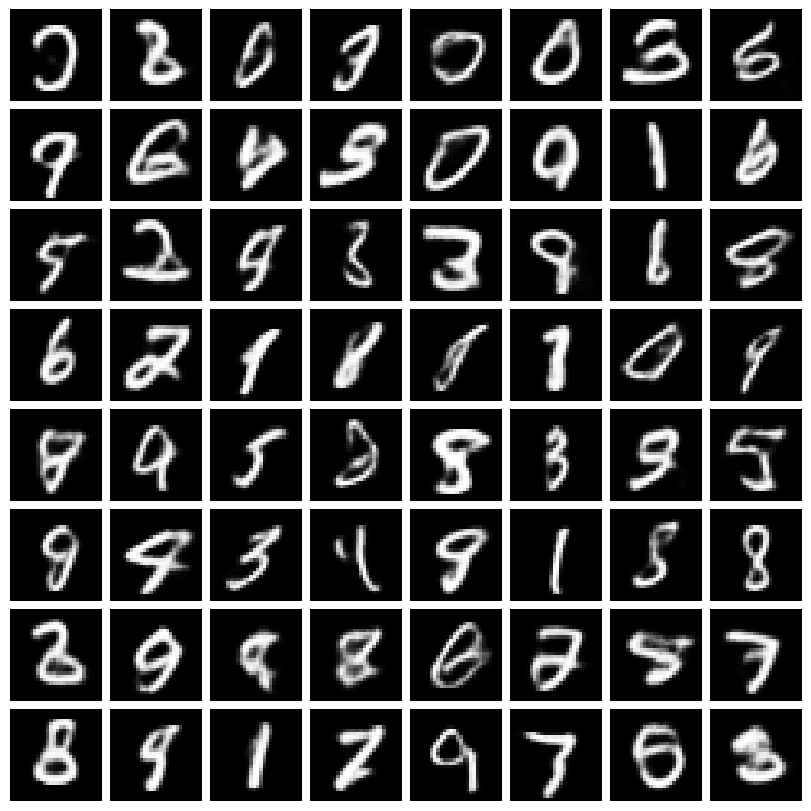

In [204]:
## generate new images by VAE

n_cols, n_rows = 8, 8

sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)

fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")